<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/qf-workshop-2021/introduction-to-machine-learning/blob/main/1_notebooks/introduction-to-machine-learning.ipynb">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Supervised and Unsupervised Models

## What is Supervised Learning

### Linear Regression

A linear model makes a prediction by simply computing a weighted
sum of the input features, plus a constant called the *bias* term (also called the *intercept*
term):

\begin{equation}
\hat y = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \dots + \theta_n x_n
\end{equation}

where:

- $\hat y$ is the predicted value;
- $n$ is the number of features;
- $x_i$ is the $i^{th}$ feature value;
- $\theta_j$ is the $j^{th}$ model parameter (including the bias term $\theta_0$ and the feature weights $\theta_1, \theta_2, \dots, \theta_n$

Training a model means setting its parameters so that the model best fits the training set. For this purpose, we first need a measure of how well (or poorly) the model fits the training data. The most common performance measure of a regression model is the Root Mean Square Error (RMSE), therefore, to train a Linear Regression model, you need to find the value of $\theta$ that minimizes the RMSE. In practice, it is simpler to minimize the Mean Square Error (MSE) than the RMSE, and it leads to the same result.


### Example 1 - Predicting Iowa House Prices (from Kaggle)

In [1]:
# loading packages 

import os

import pandas as pd
import numpy as np

# plotting packages
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clrs

# Kmeans algorithm from scikit-learn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

#### The Problem

The objective is to predict the prices of house in Iowa from features. We have 800 observations in training set, 600 in validation set, and 508 in test set

#### Categorical Features

Categorical features are features where there are a number of non-numerical alternatives. We can define a dummy variable for each alternative. The variable equals 1 if the alternative is true and zero otherwise. This is known as **one-hot encoding**.
But sometimes we do not have to do this because there is a natural ordering of variables. For example in this problem one of the categorical features is concerned with the basement quality as indicated by the ceiling height. The categories are:

- *Excellent (< 100 inches)*
- *Good (90-99 inches)*
- *Typical (80-89 inches)*
- *Fair (70-79 inches)*
- *Poor (< 70 inches)*
- *No Basement*

This is an example of a categorical variable where *there is* a natural ordering. We created a new variable that had a values of 5, 4, 3, 2, 1 and 0 for the above six categories respectively.

The other categorical features specifies the location of the house as in one of 25 neighborhoods. We introduce 25 dummy variables with a one-hot encoding. The dummy variable equals one for an observation if the neighborhood is that in which the house is located and zero otherwise.

#### Loading data (J. C. Hull, 2019, Chapter 3)

To illustrate the regression techniques discussed in this chapter we will use a total of 48 feature. 21 are numerical and two are categorical and to this we had, as discussed above, 25 categorical variables for the neighborhoods. 

In [2]:
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    uploaded = files.upload()
    path = ''
else:
    path = './data/'

In [3]:
# Both features and target have already been scaled: mean = 0; SD = 1
data = pd.read_csv(path + 'Houseprice_data_scaled.csv') 
data.head()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,OLDTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,Bsmt Qual,Sale Price
0,-0.199572,0.652747,-0.512407,1.038851,0.875754,0.597837,-0.937245,-0.482464,-0.808820,1.203988,...,-0.286942,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,-0.091644,0.584308,0.358489
1,-0.072005,-0.072527,2.189741,0.136810,-0.432225,1.218528,-0.635042,0.490326,0.276358,-0.789421,...,-0.286942,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,10.905682,0.584308,0.008849
2,0.111026,0.652747,-0.512407,0.972033,0.827310,0.095808,-0.296754,-0.329118,-0.637758,1.231999,...,-0.286942,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,-0.091644,0.584308,0.552733
3,-0.077551,0.652747,-0.512407,-1.901135,-0.722887,-0.520319,-0.057698,-0.722067,-0.528171,0.975236,...,-0.286942,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,-0.091644,-0.577852,-0.528560
4,0.444919,1.378022,-0.512407,0.938624,0.730423,0.481458,-0.170461,0.209990,-0.036366,1.668495,...,-0.286942,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,-0.091644,0.584308,0.895898


First of all check how many records we have

In [4]:
print("Number of available data = "  + str(len(data.index)))

Number of available data = 2908


Before starting we emphasize the need to divide all available data into three parts: a **training set**, a **validation set** and a **test set**. The training set is used to determine parameters for trial models. The validation set is used to determine the extent to chich the models created from the training set generalize to new data. Finally, the test set is used as a final estimate of the accuracy of the chosen model. 

We had 2908 observations. We split this as follows: 1800 in the training set, 600 in the validation set and 508 in the test set.

In [5]:
# First 1800 data items are training set; the next 600 are the validation set
train = data.iloc[:1800] 
val = data.iloc[1800:2400]

We now procede to create **labels** and **features**. As we have already said, the labels are the values of the target that is to be predicted, in this case the 'Sale Price', and we indicate that whit 'y':

In [6]:
y_train, y_val = train[['Sale Price']], val[['Sale Price']] 

The features and dummy variables were scaled using the Z-score method. Also the target values (i.e. the house prices) have been scaled with the Z-score method. The features are the variables from which the predictions are to be made and, in this case, can be obtained simply dropping the column 'Sale Price' from our dataset:

In [7]:
X_train, X_val = train.drop('Sale Price', axis=1), val.drop('Sale Price', axis=1)

In [8]:
X_train.columns

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr',
       'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV',
       'Mitchel', 'Names', 'NoRidge', 'NPkVill', 'NriddgHt', 'NWAmes',
       'OLDTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber',
       'Veenker', 'Bsmt Qual'],
      dtype='object')

#### Linear Regression with sklearn

In [9]:
# Importing models
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

In [10]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [11]:
lr.intercept_

array([-3.06335941e-11])

In [12]:
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train.columns),
        list(lr.intercept_) + list(lr.coef_[0])
    ]
)
coeffs

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,intercept,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,NWAmes,OLDTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,Bsmt Qual
1,-3.06336e-11,0.0789996,0.214395,0.0964787,0.160799,0.0253524,0.0914664,-0.0330798,0.138199,0.152786,...,-0.0517591,-0.026499,-0.00414298,-0.0181341,-0.0282754,0.0275063,0.0630586,-0.00276173,0.00240311,0.0113115


In [13]:
# Create dataFrame with corresponding feature and its respective coefficients
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train.columns),
        list(lr.intercept_) + list(lr.coef_[0])
    ]
).transpose().set_index(0)
coeffs

,1
0,
intercept,-3.06336e-11
LotArea,0.0789996
OverallQual,0.214395
OverallCond,0.0964787
YearBuilt,0.160799
YearRemodAdd,0.0253524
BsmtFinSF1,0.0914664
BsmtUnfSF,-0.0330798
TotalBsmtSF,0.138199


In [14]:
len(coeffs.index)

48

In [15]:
pred_t=lr.predict(X_train)
mse(y_train,pred_t)

0.11401526431246334

In [16]:
pred_v=lr.predict(X_val)
mse(y_val,pred_v)

0.11702499460121657

For the data we are considering it turns out that this regression model generalizes well. The mean squared error for the validation set was only a little higher than that for the training set. However linear regression with no regularization leads to some strange results because of the correlation between features. For example it makes no sense that the weights for number of full bathrooms and number of bedrooms are negative!

In [17]:
x1 = X_train['GrLivArea']
x2 = X_train['BedroomAbvGr']
x1.corr(x2)

0.5347396038733939

###### Ridge Regression

In [18]:
# Importing Ridge
from sklearn.linear_model import Ridge

We try using Ridge regression with different values of the hyperparameter $\lambda$. The following code shows the effect of this parameter on the prediction error. 

In [19]:
# The alpha used by Python's ridge should be the lambda in Hull's book times the number of observations
alphas=[0.01*1800, 0.02*1800, 0.03*1800, 0.04*1800, 0.05*1800, 0.075*1800,0.1*1800,0.2*1800, 0.4*1800]
mses=[]
for alpha in alphas:
    ridge=Ridge(alpha=alpha)
    ridge.fit(X_train,y_train)
    pred=ridge.predict(X_val)
    mses.append(mse(y_val,pred))
    print(mse(y_val,pred))

0.11703284346091342
0.11710797319752984
0.11723952924901117
0.11741457158889518
0.1176238406871145
0.11825709631198021
0.11900057469147927
0.1225464999629295
0.13073599680747128


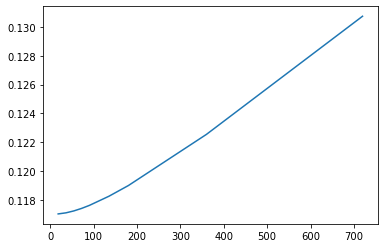

In [20]:
plt.plot(alphas, mses)

As expected the prediction error increases as $\lambda$ increases. Values of $\lambda$ in the range $0$ to $0.1$ might be reasonably be considered because prediction errors increases only slightly when $\lambda$ is in this range. However it turns out that the improvement in the model is quite small for these values of $\lambda$.

###### Lasso

In [21]:
# Import Lasso
from sklearn.linear_model import Lasso

In [22]:
# Here we produce results for alpha=0.05 which corresponds to lambda=0.1 in Hull's book
lasso = Lasso(alpha=0.05)
lasso.fit(X_train, y_train)

Lasso(alpha=0.05)

In [23]:
# DataFrame with corresponding feature and its respective coefficients
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train.columns),
        list(lasso.intercept_) + list(lasso.coef_)
    ]
).transpose().set_index(0)
coeffs

,1
0,
intercept,-1.25303e-11
LotArea,0.0443042
OverallQual,0.298079
OverallCond,0
YearBuilt,0.0520907
YearRemodAdd,0.0644712
BsmtFinSF1,0.115875
BsmtUnfSF,-0
TotalBsmtSF,0.10312


###### Lasso with different levels of alpha and its mse

In [24]:
# We now consider different lambda values. The alphas are half the lambdas
alphas=[0.01/2, 0.02/2, 0.03/2, 0.04/2, 0.05/2, 0.06/2, 0.08/2, 0.09/2, 0.1/2]
mses=[]
for alpha in alphas:
    lasso=Lasso(alpha=alpha)
    lasso.fit(X_train,y_train)
    pred=lasso.predict(X_val)
    mses.append(mse(y_val,pred))
    print("lambda = " + '{:<05}'.format(alpha) + " - mse = " + str(round(mse(y_val, pred),6)))

lambda = 0.005 - mse = 0.116548
lambda = 0.010 - mse = 0.116827
lambda = 0.015 - mse = 0.118033
lambda = 0.020 - mse = 0.120128
lambda = 0.025 - mse = 0.123015
lambda = 0.030 - mse = 0.126462
lambda = 0.040 - mse = 0.133492
lambda = 0.045 - mse = 0.137016
lambda = 0.050 - mse = 0.140172


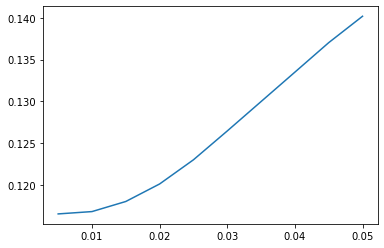

In [25]:
plt.plot(alphas, mses)

Lasso regression leads to more interesting results. In the plot above you can see how the error in the validation set changes as tha value of the lasso $\lambda$ increases. For small values of $\lambda$ the error is actually less than when $\lambda = 0$ but as $\lambda$ increases beyond about $0.03$ the error starts to increase. A value of $\lambda = 0.04$ could be chosen.   

## What is Unsupervised Learning

Unsupervised learning uses machine learning algorithms to analyze and cluster unlabeled datasets. These algorithms discover hidden patterns or data groupings without the need for human intervention. Its ability to discover similarities and differences in information make it the ideal solution for exploratory data analysis, cross-selling strategies, customer segmentation, and image recognition.

### *k*-Means Clustering

*k*-means clustering is one of the simplest and popular unsupervised machine learning algorithms.
Typically, unsupervised algorithms make inferences from datasets using only input vectors without referring to known, or labelled, outcomes. The objective of K-means is simple: group similar data points together and discover underlying patterns. To achieve this objective, K-means looks for a fixed number (k) of clusters in a dataset.

A cluster refers to a collection of data points aggregated together because of certain similarities. You’ll define a target number k, which refers to the number of centroids you need in the dataset. A centroid is the imaginary or real location representing the center of the cluster.

Every data point is allocated to each of the clusters through reducing the in-cluster sum of squares.
In other words, the K-means algorithm identifies k number of centroids, and then allocates every data point to the **nearest** cluster, while keeping the centroids as small as possible.

The ‘means’ in the K-means refers to averaging of the data; that is, finding the centroid.

<!--
<div>
<img src="K-means_convergence.gif" width="450"/>
</div>
-->
![caption](K-means_convergence.gif)

By Chire - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=59409335

#### How the K-means algorithm works

To process the learning data, the K-means algorithm in data mining starts with a first group of randomly selected centroids, which are used as the beginning points for every cluster, and then performs iterative (repetitive) calculations to optimize the positions of the centroids. It halts creating and optimizing clusters when either:

- The centroids have stabilized — there is no change in their values because the clustering has been successful.
- The defined number of iterations has been achieved.

#### A Distance Measure

For clustering we need a distance measure. The simplest distance measure is the Euclidean Distance measure:

$$
Distance = \sqrt{(x_B-x_B)^2 + (y_B - y_A)^2}
$$

#### K-means algorithm example problem
Let’s see the steps on how the K-means machine learning algorithm works using the Python programming language.
We’ll use the Scikit-learn library and some random data to illustrate a K-means clustering simple explanation.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

Here is the code for generating some random data in a two-dimensional space:

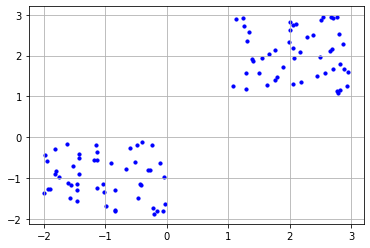

In [27]:
X  =    -2 * np.random.rand(100,2)
X1 = 1 + 2 * np.random.rand(50,2)
X[50:100, :] = X1
plt.scatter(X[ : , 0], X[ :, 1], s = 10, c = 'b')
plt.grid()
plt.show()

This give us two sets approximately centered about (-1,-1) and (2, 2). We’ll use some of the available functions in the Scikit-learn library to process the randomly generated data.

In [28]:
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=2)
Kmean.fit(X)

KMeans(n_clusters=2)

In this case, we arbitrarily gave k (n_clusters) an arbitrary value of two.
Here is the output of the K-means parameters we get if we run the code:

In [29]:
#KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
# n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
# random_state=None, tol=0.0001, verbose=0)

In [30]:
KMeans(max_iter=300, n_clusters=2, tol=0.0001)

KMeans(n_clusters=2)

In [31]:
Kmean.cluster_centers_

array([[ 2.11896647,  2.04141105],
       [-1.02802583, -0.98355376]])

Let's display the cluster centroids

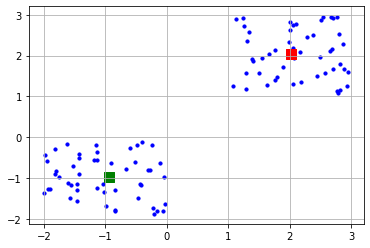

In [32]:
plt.scatter(X[ : , 0], X[ : , 1], s =10, c='b')
plt.scatter(-0.94665068, -0.97138368, s=100, c='g', marker='s')
plt.scatter( 2.01559419,  2.02597093, s=100, c='r', marker='s')
plt.grid()
plt.show()

Here is the code for getting the labels property of the K-means clustering example dataset; that is, how the data points are categorized into the two clusters.

In [33]:
Kmean.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

As you can see above, 50 data points belong to the 0 cluster while the rest belong to the 1 cluster.

For example, let’s use the code below for predicting the cluster of a data point:

In [34]:
sample_test=np.array([1.5,1.5])
second_test=sample_test.reshape(1, -1)
Kmean.predict(second_test)

array([0])

### Example 2 -  Country Risk

In [35]:
# loading packages 

import os

import pandas as pd
import numpy as np

# plotting packages
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clrs

# Kmeans algorithm from scikit-learn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

#### The Country Risk Dataset (J. C. Hull, 2019, Chapter 2)

Consider the problem of understanding the risk of countries for foreign investment. Among the features that can be used for this are:

- GDP growth rate (IMF)
- Corruption index (Transparency international)
- Peace index (Institute for Economics and Peace)
- Legal Risk Index (Property Rights Association)

Values for each of the features for 122 countries are found in the `countryriskdata.csv` (available [here](http://www-2.rotman.utoronto.ca/~hull))   

In [36]:
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    uploaded = files.upload()
    path = ''
else:
    path = './data/'

In [37]:
# load raw data
raw = pd.read_csv(os.path.join(path, 'countryriskdata.csv'))

# check the raw data
print("Size of the dataset (row, col): ", raw.shape)
print("\nFirst 5 rows\n", raw.head(n=5))

Size of the dataset (row, col):  (122, 6)

First 5 rows
      Country Abbrev  Corruption  Peace  Legal  GDP Growth
0    Albania     AL          39  1.867  3.822       3.403
1    Algeria     DZ          34  2.213  4.160       4.202
2  Argentina     AR          36  1.957  4.568      -2.298
3    Armenia     AM          33  2.218  4.126       0.208
4  Australia     AU          79  1.465  8.244       2.471


The GDP growth rate (%) is typically a positive or negative number with a magnitude less than 10. The corruption index is on a scale from 0 (highly corrupt) to 100 (no corruption). The peace index is on a scale from 1 (very peaceful) to 5 (not at all peaceful). The legal risk index runs from 0 to 10 (with high values being favorable).

### Simple exploratory analysis

**Print summary statistics**

Note that all features have quite different variances, and Corruption and Legal are highly correlated.

In [38]:
# print summary statistics
print("\nSummary statistics\n", raw.describe())
print("\nCorrelation matrix\n", raw.corr())


Summary statistics
        Corruption       Peace       Legal  GDP Growth
count  122.000000  122.000000  122.000000  122.000000
mean    46.237705    2.003730    5.598861    2.372566
std     19.126397    0.447826    1.487328    3.241424
min     14.000000    1.192000    2.728000  -18.000000
25%     31.250000    1.684750    4.571750    1.432250
50%     40.000000    1.969000    5.274000    2.496000
75%     58.750000    2.280500    6.476750    4.080000
max     90.000000    3.399000    8.633000    7.958000

Correlation matrix
             Corruption     Peace     Legal  GDP Growth
Corruption    1.000000 -0.700477  0.923589    0.102513
Peace        -0.700477  1.000000 -0.651961   -0.199855
Legal         0.923589 -0.651961  1.000000    0.123440
GDP Growth    0.102513 -0.199855  0.123440    1.000000


**Plot histogram**

Note that distributions for GDP Growth is quite skewed.

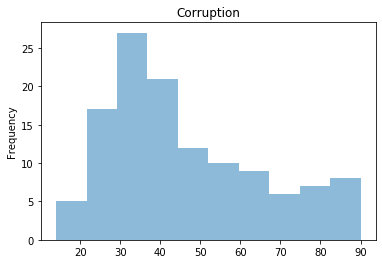

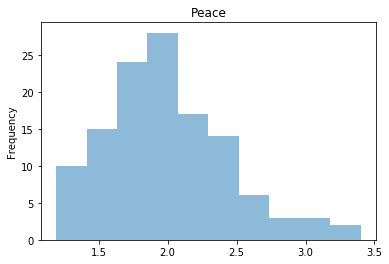

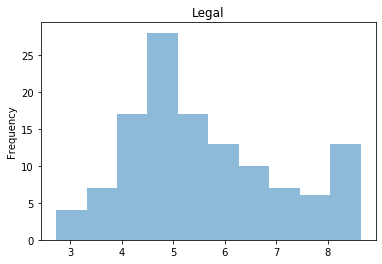

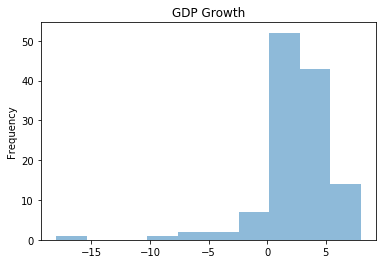

In [39]:
# plot histograms
plt.figure(1)
raw['Corruption'].plot(kind = 'hist', title = 'Corruption', alpha = 0.5)

plt.figure(2)
raw['Peace'].plot(kind = 'hist', title = 'Peace', alpha = 0.5)

plt.figure(3)
raw['Legal'].plot(kind = 'hist', title = 'Legal', alpha = 0.5)

plt.figure(4)
raw['GDP Growth'].plot(kind = 'hist', title = 'GDP Growth', alpha = 0.5)

plt.show()

### K means cluster

**Pick features & normalization**

Since Corruption and Legal are highly correlated, we drop the Corruption variable, i.e., we pick three features for this analysis, Peace, Legal and GDP Grwoth. Let's normalize all the features, effectively making them equally weighted.

Ref. [Feature normalization.](https://stats.stackexchange.com/questions/21222/are-mean-normalization-and-feature-scaling-needed-for-k-means-clustering)

In [40]:
X = raw[['Peace', 'Legal', 'GDP Growth']]
X = (X - X.mean()) / X.std()
print(X.head(5))

      Peace     Legal  GDP Growth
0 -0.305319 -1.194666    0.317896
1  0.467304 -0.967413    0.564392
2 -0.104348 -0.693096   -1.440899
3  0.478469 -0.990273   -0.667782
4 -1.202990  1.778450    0.030368


### Perform elbow method

In cluster analysis, the elbow method is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use. The same method can be used to choose the number of parameters in other data-driven models, such as the number of principal components to describe a data set.

For example in the following picture k=4 is suggested


<div>
<img src="pic_13_C.png" width="400"/>
</div>

In our case, the marginal gain of adding one cluster dropped quite a bit from k=3 to k=4. We will choose k=3 (not a clear cut though).

Ref. [Determining the number of clusters in a dataset.](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set)

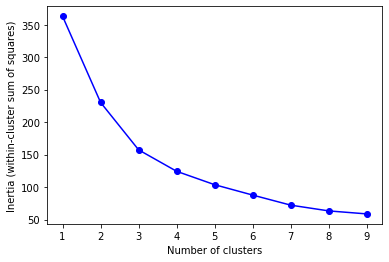

In [41]:
# https://stackoverflow.com/questions/41540751/sklearn-kmeans-equivalent-of-elbow-method

Ks = range(1, 10)
inertia = [KMeans(i).fit(X).inertia_ for i in Ks]

fig = plt.figure()
plt.plot(Ks, inertia, '-bo')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (within-cluster sum of squares)')
plt.show()

***k*-means with k=3**

In [42]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(X)

# print inertia & cluster center
print("inertia for k=3 is", kmeans.inertia_)
print("cluster centers: ", kmeans.cluster_centers_)

# take a quick look at the result
y = kmeans.labels_
print("cluster labels: ", y)

inertia for k=3 is 157.551489241025
cluster centers:  [[-0.92810589  1.16641329 -0.01445833]
 [ 1.21562552 -1.01677118 -1.61496953]
 [ 0.25320926 -0.45186802  0.43127408]]
cluster labels:  [2 2 1 1 0 0 1 2 2 0 2 2 2 0 1 2 1 2 0 1 0 2 2 0 2 2 0 1 0 2 1 2 2 0 2 0 0
 2 2 0 2 2 2 2 0 0 2 2 2 0 2 0 2 0 2 2 2 0 2 2 1 1 0 2 2 0 2 2 0 2 2 2 2 2
 2 0 0 2 1 0 2 2 2 2 2 2 0 0 0 2 1 2 2 2 2 2 0 0 0 0 0 2 0 0 0 2 2 2 1 2 2
 2 1 0 0 0 0 1 2 1 2 1]


**Visualize the result (3D plot)**

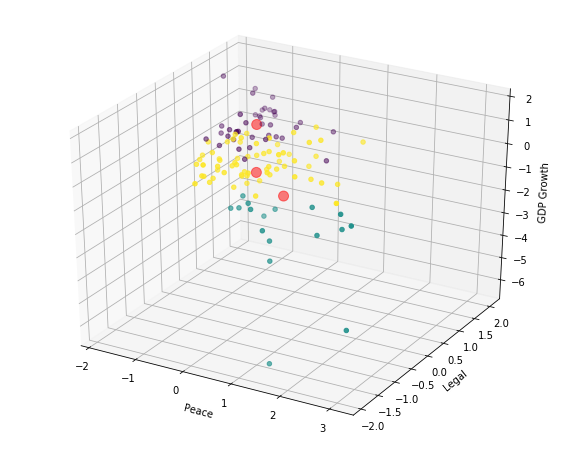

In [43]:
# set up the color
norm = clrs.Normalize(vmin=0.,vmax=y.max())
cmap = cm.viridis

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], c=cmap(norm(y)), marker='o')

centers = kmeans.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.5, marker='o')

ax.set_xlabel('Peace')
ax.set_ylabel('Legal')
ax.set_zlabel('GDP Growth')

plt.show()

**Visualize the result (3 2D plots)**

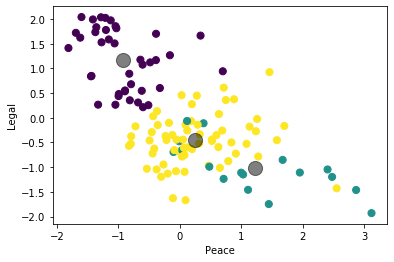

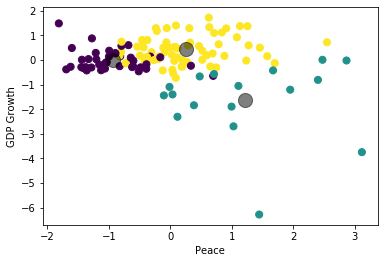

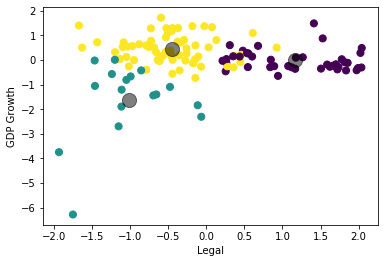

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt

figs = [(0, 1), (0, 2), (1, 2)]
labels = ['Peace', 'Legal', 'GDP Growth']

for i in range(3):
    fig = plt.figure(i)
    plt.scatter(X.iloc[:,figs[i][0]], X.iloc[:,figs[i][1]], c=cmap(norm(y)), s=50)
    plt.scatter(centers[:, figs[i][0]], centers[:, figs[i][1]], c='black', s=200, alpha=0.5)
    plt.xlabel(labels[figs[i][0]])
    plt.ylabel(labels[figs[i][1]])

plt.show()

**Visualize the result (3 2D plots)**

plot country abbreviations instead of dots.

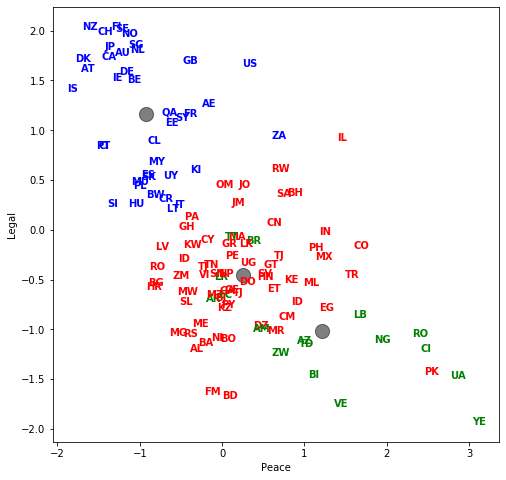

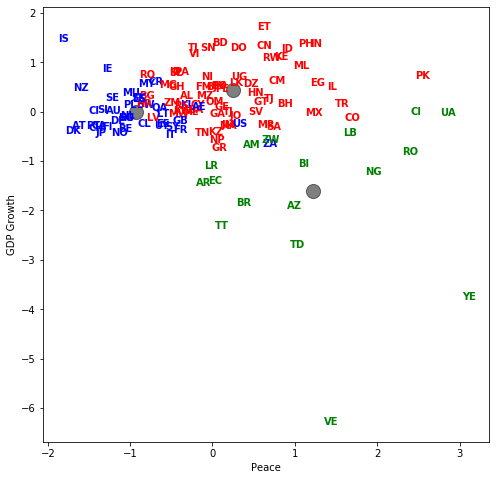

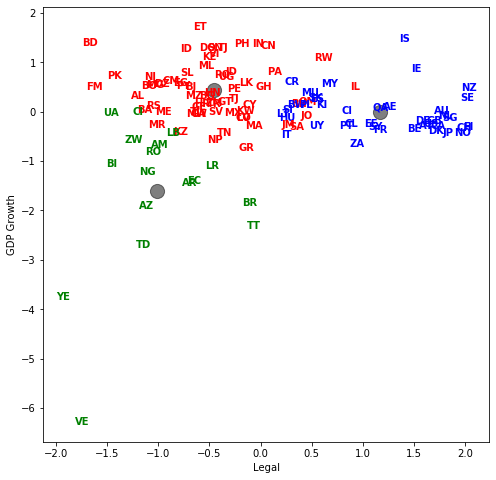

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt

figs = [(0, 1), (0, 2), (1, 2)]
labels = ['Peace', 'Legal', 'GDP Growth']
colors = ['blue','green', 'red']

for i in range(3):
    fig = plt.figure(i, figsize=(8, 8))
    x_1 = figs[i][0]
    x_2 = figs[i][1]
    plt.scatter(X.iloc[:, x_1], X.iloc[:, x_2], c=y, s=0, alpha=0)
    plt.scatter(centers[:, x_1], centers[:, x_2], c='black', s=200, alpha=0.5)
    for j in range(X.shape[0]):
        plt.text(X.iloc[j, x_1], X.iloc[j, x_2], raw['Abbrev'].iloc[j], 
                 color=colors[y[j]], weight='semibold', horizontalalignment = 'center', verticalalignment = 'center')
    plt.xlabel(labels[x_1])
    plt.ylabel(labels[x_2])

plt.show()

### List the result

In [ ]:
result = pd.DataFrame({'Country':raw['Country'], 'Abbrev':raw['Abbrev'], 'Label':y})
with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
    print(result.sort_values('Label'))


### Silhouette Analysis

For each observation $i$ calculate $a(i)$, the average distance from other observations in its cluster, and $b(i)$, the average distance from observations in the closest other cluster. The silhouette score for observation $i$, $s(i)$, is defined as 
		\begin{equation}
		s(i) = \frac{b(i)-a(i)}{\max[a(i),b(i)]}
\end{equation}		   

Choose the number of clusters that maximizes the average silhouette score across all observations

In [ ]:
# Silhouette Analysis
range_n_clusters = [2,3,4,5,6,7,8,9,10]
silhouette       = []
for n_clusters in range_n_clusters:
    clusterer=KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels=clusterer.fit_predict(X)
    silhouette_avg=silhouette_score(X,cluster_labels)
    silhouette.append(silhouette_avg)
    #print("For n_clusters=", n_clusters,
    #      "The average silhouette_score is :", silhouette_avg)

In [ ]:
plt.plot(range_n_clusters, silhouette)

## References

John C. Hull, **Machine Learning in Business: An Introduction to the World of Data Science**, Amazon, 2019.

Paul Wilmott, **Machine Learning: An Applied Mathematics Introduction**, Panda Ohana Publishing, 2019.